This is a tutorial about how to do automated label transfer for two tissues at once, using the Universal Cell Embedding and the `anndict` package to simplify the syntax. To do this, you will need all anndatas to be previously embedded in UCE-space. Cellxgene census has some pre-embedded data (we'll use that here).  To embed your own data in UCE-space, go to https://github.com/snap-stanford/UCE and follow the instructions there.

In [4]:
#import adict package
import anndict as adt

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
#load data for training
import cellxgene_census

census = cellxgene_census.open_soma(census_version="2023-12-15")
adata_train = cellxgene_census.get_anndata(
    census,
    organism = "homo_sapiens",
    measurement_name = "RNA",
    obs_value_filter = "(dataset_id == '53d208b0-2cfd-4366-9866-c3c6114081bc') & ((tissue_general == 'kidney') | (tissue_general == 'liver'))",
    obs_embeddings = ["uce"]
)

In [5]:
#load data to annotate
adata_annotate = cellxgene_census.get_anndata(
    census,
    organism = "mus_musculus",
    measurement_name = "RNA",
    obs_value_filter = "(dataset_id == '48b37086-25f7-4ecd-be66-f5bb378e3aea') & ((tissue_general == 'kidney') | (tissue_general == 'liver'))",
    obs_embeddings = ["uce"]
)

In [6]:
adt.display_html_summary(adt.summarize_metadata(adata_train, columns = ['tissue','cell_type', 'dataset_id*tissue']))

,count
kidney,9641
liver,5007
,count
kidney epithelial cell,8331
macrophage,1702
hepatocyte,1558
monocyte,612
endothelial cell of hepatic sinusoid,421
mature NK T cell,376
endothelial cell,362


In [7]:
adt.display_html_summary(adt.summarize_metadata(adata_annotate, columns = ['tissue','cell_type', 'dataset_id*tissue']))

,count
kidney,21647
liver,7294
,count
kidney proximal convoluted tubule epithelial cell,4460
B cell,3327
epithelial cell of proximal tubule,3053
hepatocyte,2929
Kupffer cell,2546
kidney loop of Henle thick ascending limb epithelial cell,1554
lymphocyte,1536


In [8]:
#build an adata dict of both train and test data
adata_dict = {"train": adata_train, "test": adata_annotate}

#subset each tissue celltype down to 1k cells, dropping cell types with fewer than 20 cells
adata_dict = adt.resample_adata_dict(adata_dict, strata_keys=['tissue', 'cell_type'], min_num_cells=50, n_obs=1000)

In [9]:
#Check the results, note that 
adt.display_html_summary_adata_dict(adt.summarize_metadata_adata_dict(adata_dict, columns = ["dataset_id", "cell_type*tissue"]))

Summary for train:


Summary for test:


In [10]:
adata_dict

{'train': AnnData object with n_obs × n_vars = 6268 × 60664
     obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'tissue_cell_type'
     obsm: 'uce',
 'test': AnnData object with n_obs × n_vars = 15831 × 52417
     obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_i

In [11]:
#break train and test into per-tissue objects (the two lines below are equivalent)
# adata_dict = adt.adata_dict_fapply_return(adata_dict, adt.build_adata_dict, strata_keys = ["tissue"], desired_strata = ['kidney', 'liver'])
adata_dict = adt.subsplit_adata_dict(adata_dict, strata_keys = ["tissue"], desired_strata = ['kidney', 'liver'])

In [12]:
#the dictionary is now a nested dictionary of adata_dicts
print(adata_dict.keys())
print(adata_dict['train'].keys())

dict_keys(['train', 'test'])
dict_keys(['kidney', 'liver'])


In [13]:
#Now, train a logistic regression on each tissue in training data
#The function stable_label_adata_dict does this when setting max_iterations = 1 (with max_iterations > 1, this function is designed to do error correction on labels)

#If SLURM_CPUS_PER_TASK and/or SLURM_NTASKS environment variables are set, the function will automatically determine number of cores and multithread using adict.get_slurm_cores()
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

stable_label_results = adt.stable_label_adata_dict(adata_dict['train'],
                        feature_key='uce',
                        label_key='cell_type',
                        classifier_class=LogisticRegression,
                        max_iterations=1,
                        stability_threshold=0.01,
                        moving_average_length=5,
                        random_state=42,
                        max_iter = 1000, #args for classifer construction (here and below)
                        n_jobs=adt.get_slurm_cores())

Training classifier for kidney
Training classifier for liver


In [14]:
#apply trained classifiers to test set to create new labels
predicted_labels_dict = adt.predict_labels_adata_dict(
    adata_dict['test'],
    stable_label_results,
    feature_key='uce'
)

In [15]:
#actually assign labels back to the test
adt.update_adata_labels_with_predictions_dict(adata_dict['test'], predicted_labels_dict, new_label_key='predicted_cell_type')

Plotting UMAP for key: kidney


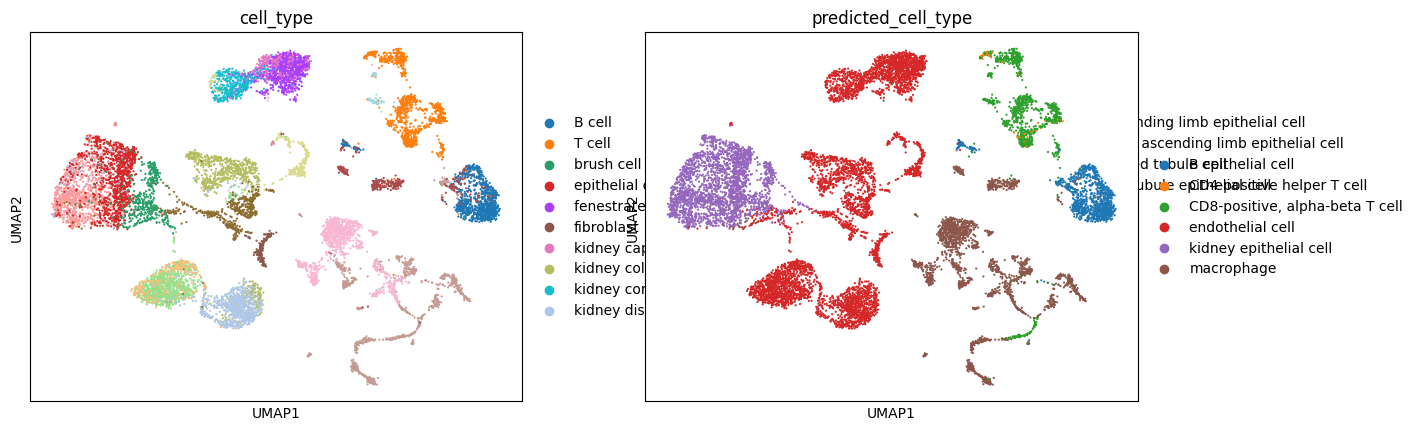

Plotting UMAP for key: liver


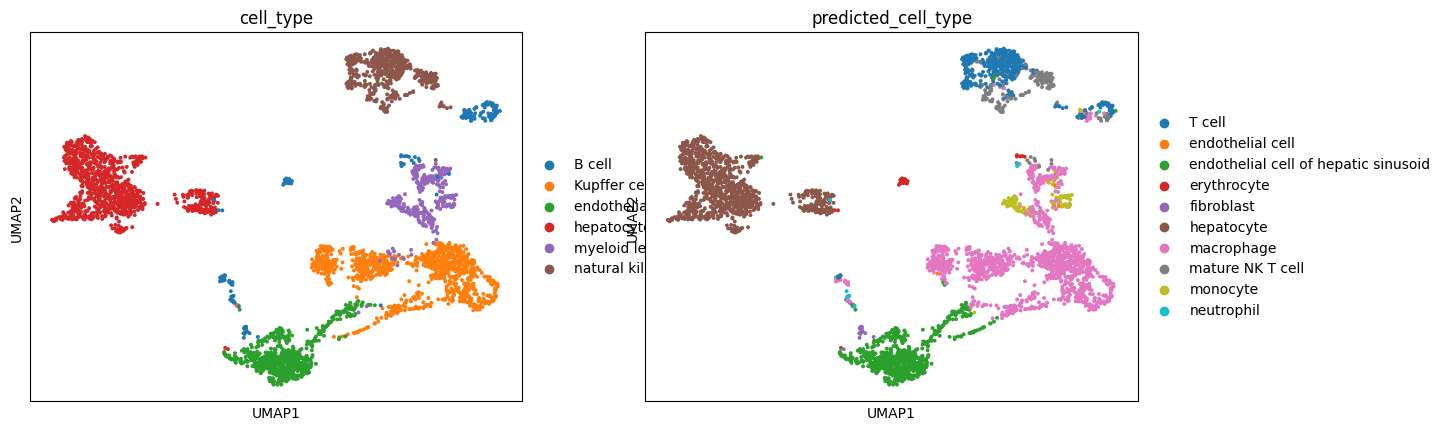

In [16]:
#calculate and plot UMAP based on UCE
adt.calculate_umap_adata_dict(adata_dict['test'], use_rep='uce')
adt.plot_umap_adata_dict(adata_dict['test'], color_by=['cell_type', 'predicted_cell_type'])

Plotting changes for kidney


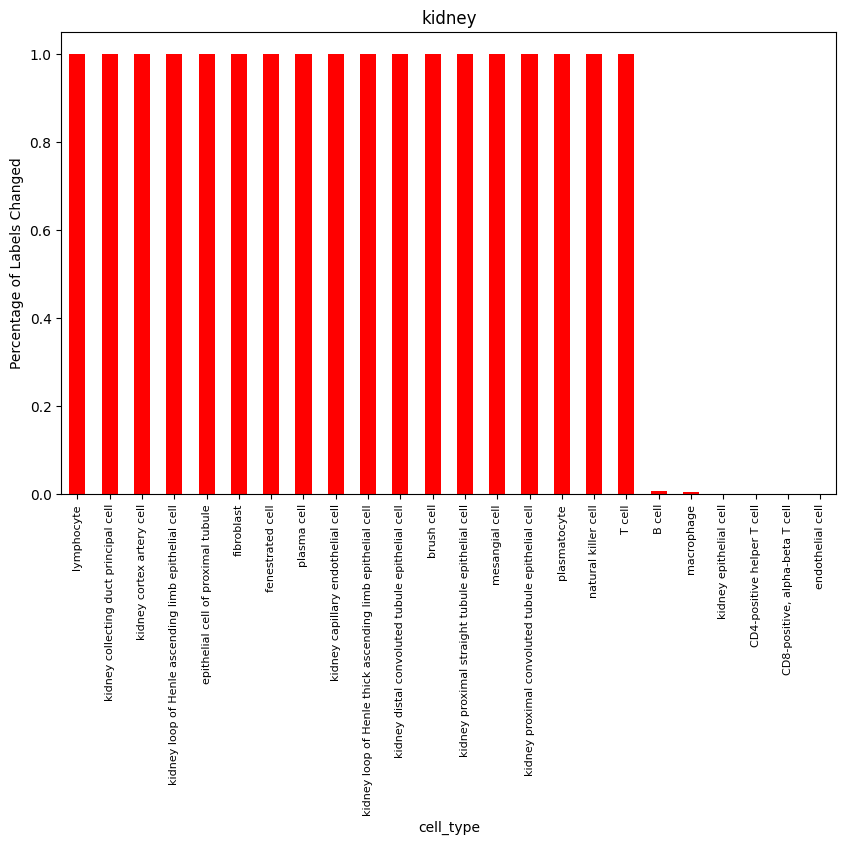

Plotting changes for liver


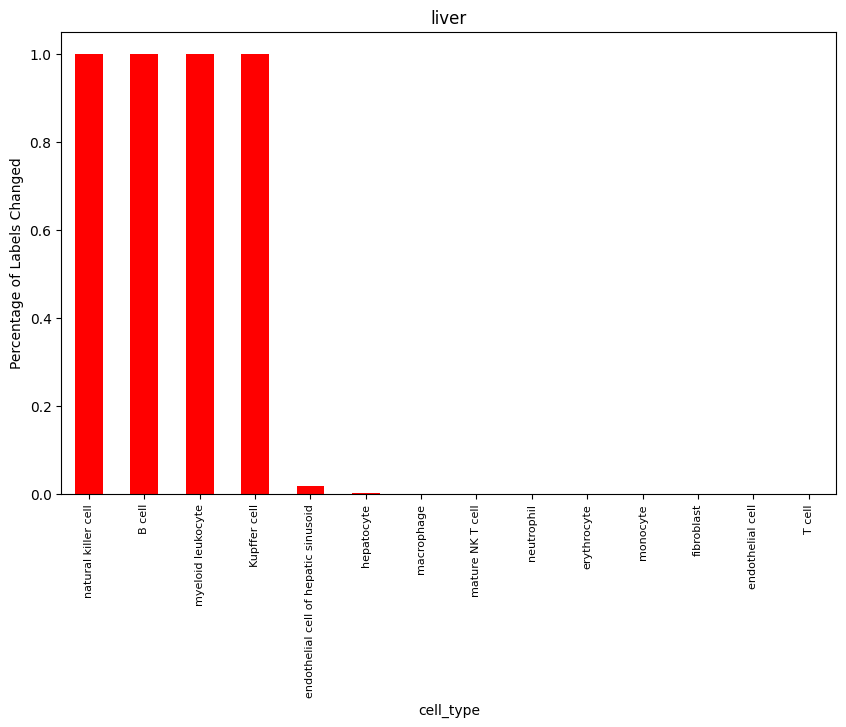

In [17]:
adt.plot_changes_adata_dict(adata_dict['test'], 'cell_type', 'predicted_cell_type', percentage=True)

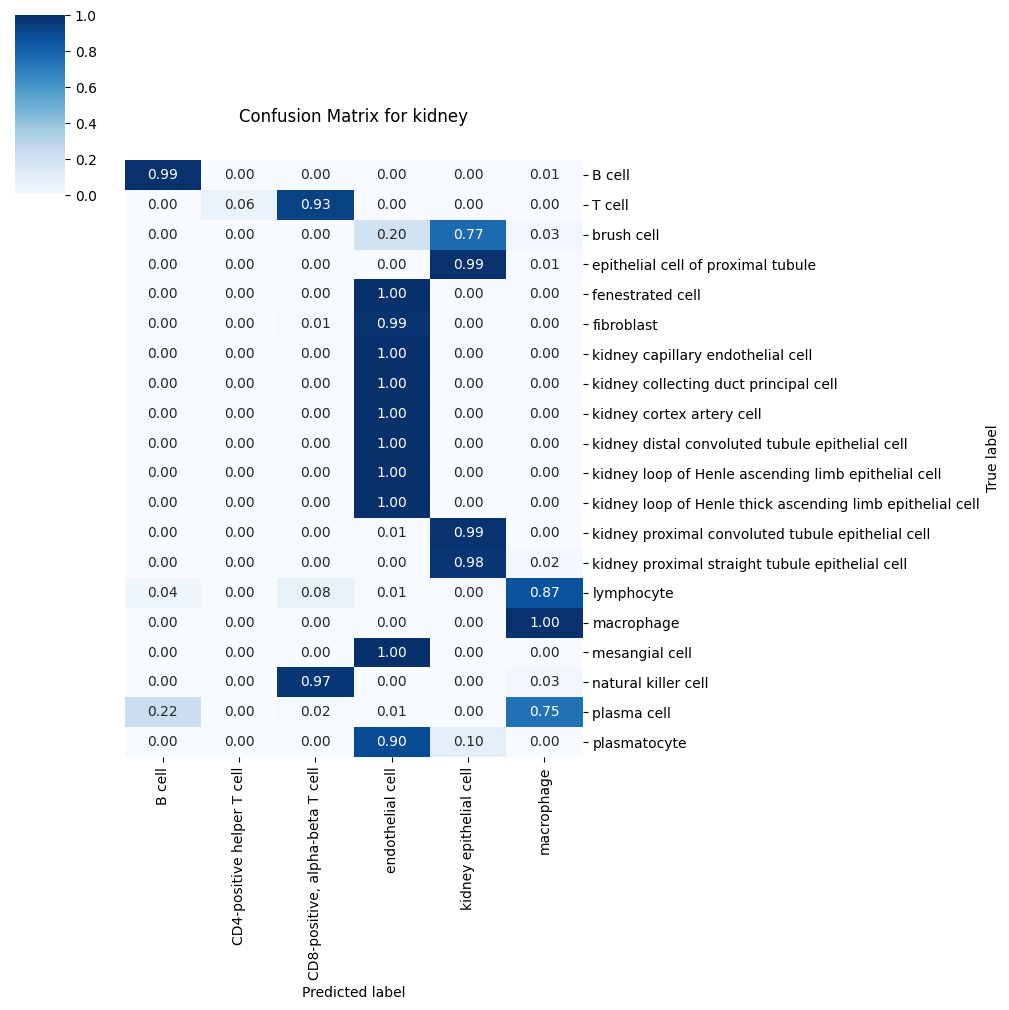

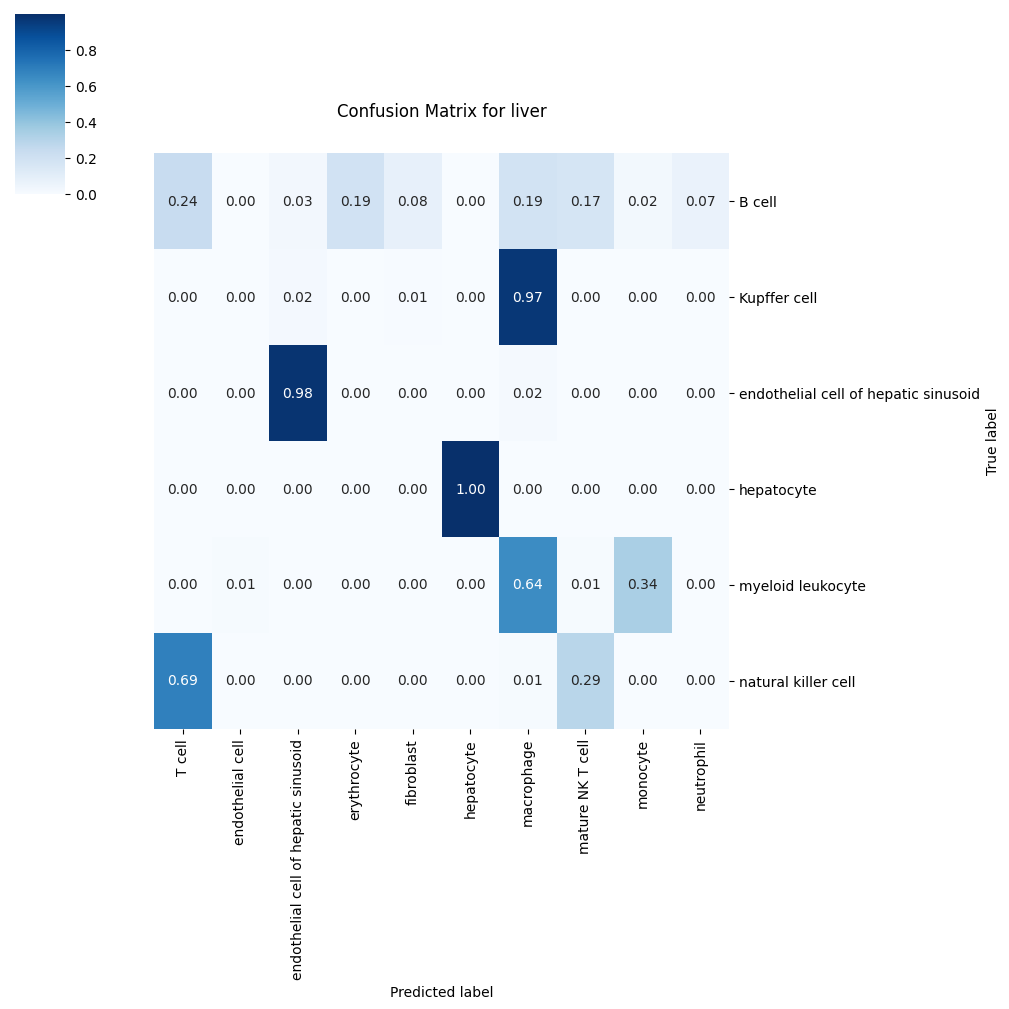

In [18]:
adt.plot_confusion_matrix_adata_dict(adata_dict['test'], 'cell_type', 'predicted_cell_type',
                                     row_color_keys=None, col_color_keys=None)